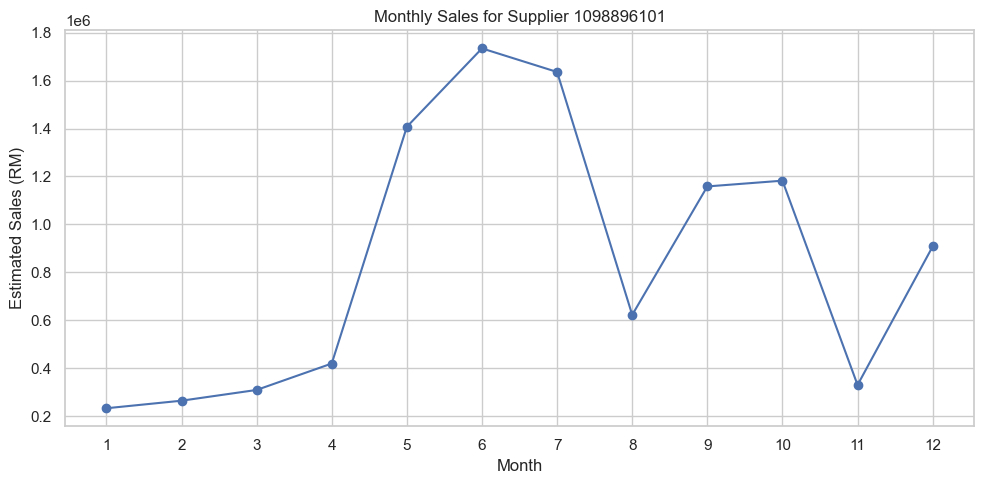

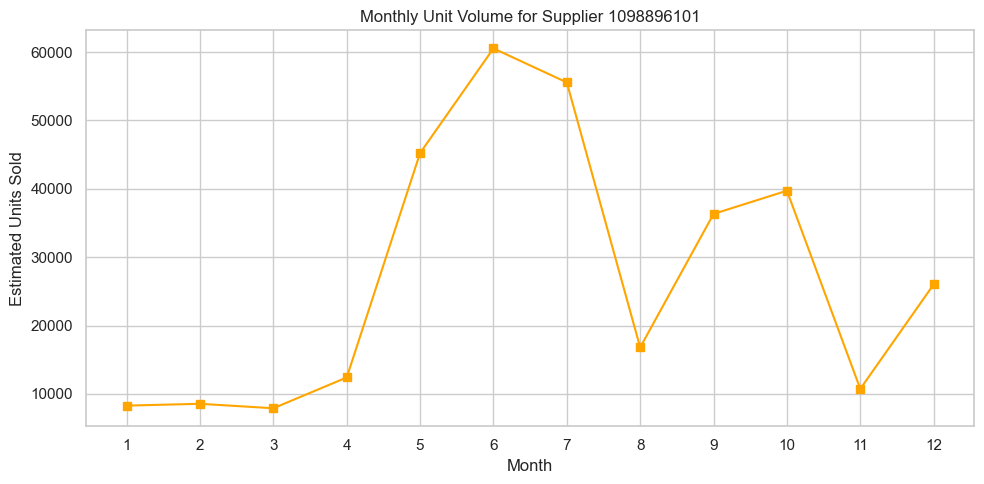

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load CSVs
sales = pd.read_csv('./CSVs/Monthly_sales_forecast.csv')
products = pd.read_csv('./CSVs/product_table.csv')

# Step 2: Merge sales with product info to get SupplierKey
merged = pd.merge(sales, products, on='ProductKey')

# Step 3: Filter for Supplier 1098896101
supplier_df = merged[merged['SupplierKey'] == 1098896101]

# Step 4: Group by month and sum estimated sales
monthly_sales = supplier_df.groupby('TransactionMonth')['EstimatedSales'].sum().reset_index()

# Step 5a: Plot the estimated sales per month
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales['TransactionMonth'], monthly_sales['EstimatedSales'], marker='o')
plt.title('Monthly Sales for Supplier 1098896101')
plt.xlabel('Month')
plt.ylabel('Estimated Sales (RM)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5b: Group by month and sum unit volume
monthly_volume = supplier_df.groupby('TransactionMonth')['EstimatedUnitVolume'].sum().reset_index()

# Plot unit volume per month
plt.figure(figsize=(10, 5))
plt.plot(monthly_volume['TransactionMonth'], monthly_volume['EstimatedUnitVolume'], marker='s', color='orange')
plt.title('Monthly Unit Volume for Supplier 1098896101')
plt.xlabel('Month')
plt.ylabel('Estimated Units Sold')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
import pandas as pd

# Load all CSVs
sales = pd.read_csv('./CSVs/Monthly_sales_forecast.csv')
products = pd.read_csv('./CSVs/product_table.csv')
suppliers = pd.read_csv('./CSVs/supplier_table.csv')
brands = pd.read_csv('./CSVs/brand_table.csv')
categories = pd.read_csv('./CSVs/product_category_table.csv')

# Merge sales + product
merged = pd.merge(sales, products, on='ProductKey', how='left')

# Merge with supplier emissions (Est_Emission_Int_x)
merged = pd.merge(merged, suppliers[['SupplierKey', 'Est_Emission_Int']], on='SupplierKey', how='left')

# Merge with brand emissions (Est_Emission_Int_y)
merged = pd.merge(merged, brands[['BrandKey', 'Est_Emission_Int']], on='BrandKey', how='left')

# Merge with category emissions
merged = pd.merge(
    merged,
    categories[['ProductCategory_Lvl1', 'ProductCategory_Lvl2', 'Est_Emission_Int']],
    on=['ProductCategory_Lvl1', 'ProductCategory_Lvl2'],
    how='left'
)

# Rename emission columns for clarity
merged = merged.rename(columns={
    'Est_Emission_Int_x': 'Supplier_Emissions',
    'Est_Emission_Int_y': 'Brand_Emissions',
    'Est_Emission_Int': 'Category_Emissions'
})

# Total Emissions per unit
merged['Total_Emissions_per_Unit'] = (
    merged['Supplier_Emissions'].fillna(0) +
    merged['Brand_Emissions'].fillna(0) +
    merged['Category_Emissions'].fillna(0)
)

# Total Emissions per row (unit volume x per unit emissions)
merged['Total_Emissions'] = merged['EstimatedUnitVolume'] * merged['Total_Emissions_per_Unit']

# Final merged dataframe is ready
merged_all = merged.copy()

# Convert margin from '34%' string to float 0.34
merged_all['Margin'] = merged_all['Margin'].str.rstrip('%').astype(float) / 100

Text(0, 0.5, 'ProductKey')

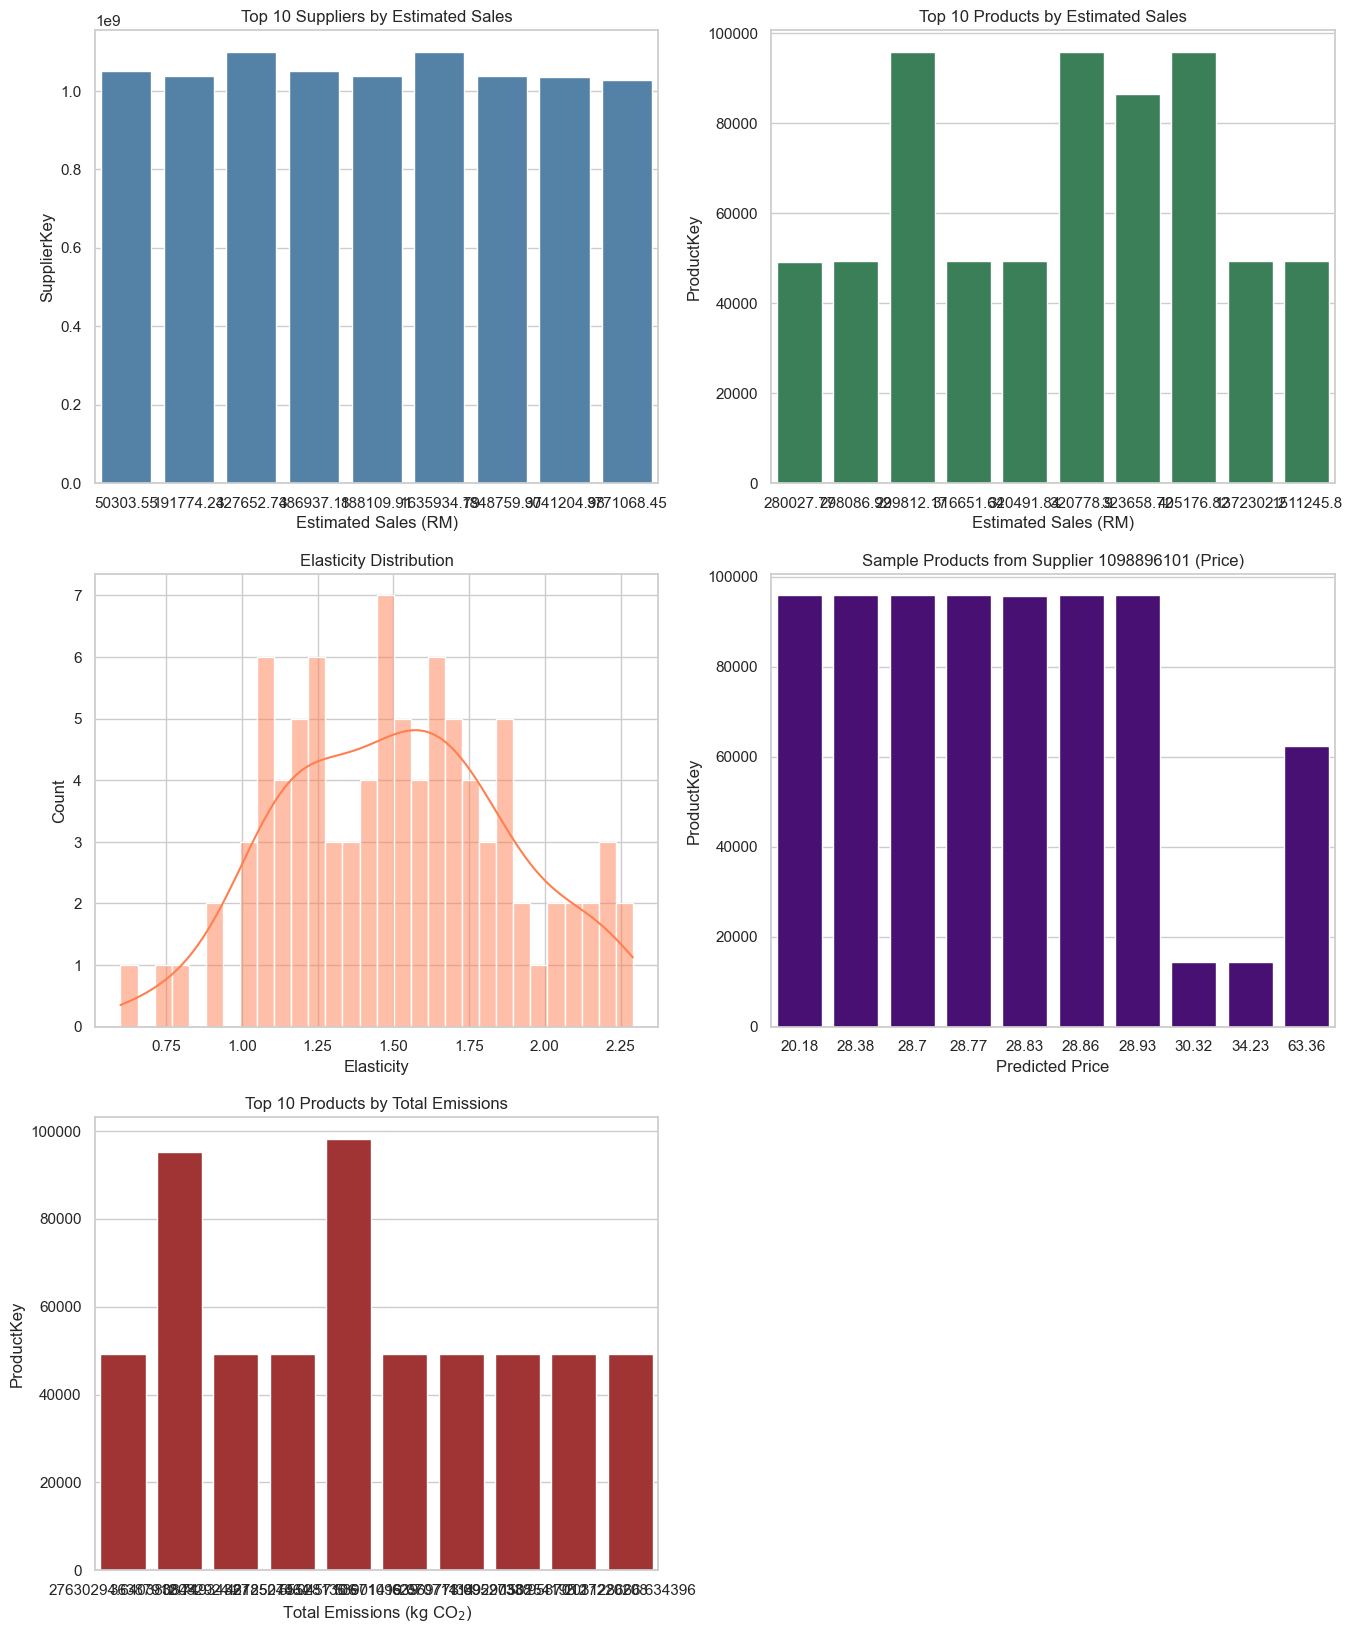

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

merged_all = merged_all[merged_all['TransactionMonth'] == 7]

# Set style
sns.set(style='whitegrid')
plt.figure(figsize=(16, 20))

# ---------- 1. Supplier Summary ----------
supplier_summary = merged_all.groupby('SupplierKey').agg({
    'EstimatedSales': 'sum',
    'EstimatedUnitVolume': 'sum',
    'Total_Emissions': 'sum'
}).reset_index().sort_values('EstimatedSales', ascending=False).head(10)

plt.subplot(3, 2, 1)
sns.barplot(data=supplier_summary, x='EstimatedSales', y='SupplierKey', color='steelblue')
plt.title('Top 10 Suppliers by Estimated Sales')
plt.xlabel('Estimated Sales (RM)')
plt.ylabel('SupplierKey')

# ---------- 2. Top Products by Sales ----------
top_products = merged_all.groupby('ProductKey').agg({
    'EstimatedSales': 'sum',
    'EstimatedUnitVolume': 'sum',
    'PredictedPrice': 'mean',
    'Elasticity': 'mean',
    'Margin': 'mean',
    'Total_Emissions_per_Unit': 'mean'
}).sort_values('EstimatedSales', ascending=False).head(10).reset_index()

plt.subplot(3, 2, 2)
sns.barplot(data=top_products, x='EstimatedSales', y='ProductKey', color='seagreen')
plt.title('Top 10 Products by Estimated Sales')
plt.xlabel('Estimated Sales (RM)')
plt.ylabel('ProductKey')

# ---------- 3. Elasticity Distribution ----------
plt.subplot(3, 2, 3)
sns.histplot(merged_all['Elasticity'], bins=30, kde=True, color='coral')
plt.title('Elasticity Distribution')
plt.xlabel('Elasticity')

# ---------- 4. Sample Supplier Products ----------
supplier_products = merged_all[merged_all['SupplierKey'] == 1098896101]
sample = supplier_products.head(10)

plt.subplot(3, 2, 4)
sns.barplot(data=sample, x='PredictedPrice', y='ProductKey', color='indigo')
plt.title('Sample Products from Supplier 1098896101 (Price)')
plt.xlabel('Predicted Price')
plt.ylabel('ProductKey')

# ---------- 5. Top Products by Emissions ----------
top_emissions = merged_all.groupby('ProductKey')['Total_Emissions'].sum().sort_values(ascending=False).head(10).reset_index()

plt.subplot(3, 2, 5)
sns.barplot(data=top_emissions, x='Total_Emissions', y='ProductKey', color='firebrick')
plt.title('Top 10 Products by Total Emissions')
plt.xlabel(r'Total Emissions (kg CO$_2$)')
plt.ylabel('ProductKey')


In [116]:
# Filter only products from the target supplier
supplier_support_df = merged_all[merged_all['SupplierKey'] == 1098896101].copy()

# Optional preview
print(f"Number of rows: {len(supplier_support_df)}")
supplier_support_df[['ProductKey', 'PredictedPrice', 'EstimatedUnitVolume', 'EstimatedSales']].head()

Number of rows: 10


,ProductKey,PredictedPrice,EstimatedUnitVolume,EstimatedSales
6,14397,30.32,778,23588.96
30,14435,34.23,2342,80166.66
534,62331,63.36,1286,81480.96
978,95792,28.83,14054,405176.82
990,95816,28.86,11115,320778.90


In [118]:
# Step 4: Apply 15% discount
supplier_support_df['NewPrice'] = supplier_support_df['PredictedPrice'] * 0.85

# Calculate % change in price (used for elasticity in Step 5)
supplier_support_df['PctPriceChange'] = (supplier_support_df['NewPrice'] - supplier_support_df['PredictedPrice']) / supplier_support_df['PredictedPrice']


# Show all rows in the DataFrame preview
pd.set_option('display.max_rows', None)

# Now preview full table with key columns
supplier_support_df[['ProductKey', 'PredictedPrice', 'NewPrice', 'PctPriceChange']]



,ProductKey,PredictedPrice,NewPrice,PctPriceChange
6,14397,30.32,25.7720,-0.15
30,14435,34.23,29.0955,-0.15
534,62331,63.36,53.8560,-0.15
978,95792,28.83,24.5055,-0.15
990,95816,28.86,24.5310,-0.15
1002,95818,28.77,24.4545,-0.15
1014,95821,28.70,24.3950,-0.15
1026,95822,28.93,24.5905,-0.15
1038,95835,28.38,24.1230,-0.15
1050,95843,20.18,17.1530,-0.15


In [122]:
# Step 5a: Calculate % volume change using elasticity
supplier_support_df['PctVolumeChange'] = -supplier_support_df['Elasticity'] * supplier_support_df['PctPriceChange']

# Step 5b: Calculate new volume
supplier_support_df['NewVolume'] = supplier_support_df['EstimatedUnitVolume'] * (1 + supplier_support_df['PctVolumeChange'])

# Optional: round new volume for realism
supplier_support_df['NewVolume'] = supplier_support_df['NewVolume'].round()

# Preview all products with price, volume change, and new volume
supplier_support_df[['ProductKey', 'PredictedPrice', 'NewPrice', 'Elasticity', 'EstimatedUnitVolume', 'NewVolume', 'PctVolumeChange']]


,ProductKey,PredictedPrice,NewPrice,Elasticity,EstimatedUnitVolume,NewVolume,PctVolumeChange
6,14397,30.32,25.7720,1.51,778,954.0,0.2265
30,14435,34.23,29.0955,1.12,2342,2735.0,0.1680
534,62331,63.36,53.8560,1.10,1286,1498.0,0.1650
978,95792,28.83,24.5055,1.28,14054,16752.0,0.1920
990,95816,28.86,24.5310,1.43,11115,13499.0,0.2145
1002,95818,28.77,24.4545,1.49,10421,12750.0,0.2235
1014,95821,28.70,24.3950,1.24,6679,7921.0,0.1860
1026,95822,28.93,24.5905,1.53,4338,5334.0,0.2295
1038,95835,28.38,24.1230,1.43,1952,2371.0,0.2145
1050,95843,20.18,17.1530,1.65,2594,3236.0,0.2475


In [154]:
# Step 6a: Recalculate original and new sales
supplier_support_df['OrigSales'] = supplier_support_df['EstimatedUnitVolume'] * supplier_support_df['PredictedPrice']
supplier_support_df['NewSales'] = supplier_support_df['NewVolume'] * supplier_support_df['NewPrice']

# Step 6b: Sales uplift
supplier_support_df['SalesUplift'] = supplier_support_df['NewSales'] - supplier_support_df['OrigSales']

# Optional: format with RM commas
supplier_support_df['OrigSales'] = supplier_support_df['OrigSales'].round(2)
supplier_support_df['NewSales'] = supplier_support_df['NewSales'].round(2)
supplier_support_df['SalesUplift'] = supplier_support_df['SalesUplift'].round(2)

# Preview key columns
supplier_support_df[['ProductKey', 'OrigSales', 'NewSales', 'SalesUplift']]


,ProductKey,OrigSales,NewSales,SalesUplift
6,14397,23588.96,24586.49,997.53
30,14435,80166.66,79576.19,-590.47
534,62331,81480.96,80676.29,-804.67
978,95792,405176.82,410516.14,5339.32
990,95816,320778.90,331143.97,10365.07
1002,95818,299812.17,311794.88,11982.71
1014,95821,191687.30,193232.80,1545.49
1026,95822,125498.34,131165.73,5667.39
1038,95835,55397.76,57195.63,1797.87
1050,95843,52346.92,55507.11,3160.19


In [170]:
# Step 7a: Calculate new and original profit (before offset cost)
supplier_support_df['OrigGrossProfit'] = supplier_support_df['OrigSales'] * supplier_support_df['Margin']
supplier_support_df['NewGrossProfit'] = supplier_support_df['NewSales'] * supplier_support_df['Margin']

# Step 7b: Subtract emission offset cost (RM 0.25 per kg CO2)
supplier_support_df['OrigOffsetCost'] = supplier_support_df['OrigEmissions']
supplier_support_df['NewOffsetCost'] = supplier_support_df['NewEmissions']

supplier_support_df['OrigProfit'] = supplier_support_df['OrigGrossProfit'] - (supplier_support_df['OrigOffsetCost'] * 0.25)
supplier_support_df['NewProfit'] = supplier_support_df['NewGrossProfit'] - (supplier_support_df['NewOffsetCost'] * 0.25)

# Step 7c: Profit uplift
supplier_support_df['ProfitUplift'] = supplier_support_df['NewProfit'] - supplier_support_df['OrigProfit']

# Round for clean viewing
supplier_support_df[['OrigProfit', 'NewProfit', 'ProfitUplift']] = supplier_support_df[['OrigProfit', 'NewProfit', 'ProfitUplift']].round(2)

# Preview profit impact
supplier_support_df[['ProductKey', 'OrigProfit', 'NewProfit', 'ProfitUplift']]


,ProductKey,OrigProfit,NewProfit,ProfitUplift
6,14397,5153.83,4844.55,-309.28
30,14435,9809.61,8225.86,-1583.75
534,62331,12372.94,11422.88,-950.06
978,95792,63426.30,60389.25,-3037.06
990,95816,68113.41,62854.08,-5259.34
1002,95818,63541.66,59034.96,-4506.70
1014,95821,34815.37,30718.53,-4096.84
1026,95822,10372.00,7892.55,-2479.45
1038,95835,4995.68,3847.47,-1148.21
1050,95843,8240.78,6949.90,-1290.88


In [174]:
# Step 8a: Emissions before and after
supplier_support_df['OrigEmissions'] = supplier_support_df['EstimatedUnitVolume'] * supplier_support_df['Total_Emissions_per_Unit']
supplier_support_df['NewEmissions'] = supplier_support_df['NewVolume'] * supplier_support_df['Total_Emissions_per_Unit']

# Step 8b: Offset cost (RM 0.25 per kg CO₂)
supplier_support_df['OrigOffsetCost'] = supplier_support_df['OrigEmissions'] * 0.25
supplier_support_df['NewOffsetCost'] = supplier_support_df['NewEmissions'] * 0.25
supplier_support_df['OffsetCostChange'] = supplier_support_df['NewOffsetCost'] - supplier_support_df['OrigOffsetCost']

# Round values
cols = ['OrigEmissions', 'NewEmissions', 'OrigOffsetCost', 'NewOffsetCost', 'OffsetCostChange']
supplier_support_df[cols] = supplier_support_df[cols].round(2)

# Preview
supplier_support_df[['ProductKey', 'OrigEmissions', 'NewEmissions', 'OrigOffsetCost', 'NewOffsetCost', 'OffsetCostChange']]


,ProductKey,OrigEmissions,NewEmissions,OrigOffsetCost,NewOffsetCost,OffsetCostChange
6,14397,11465.66,14059.43,2866.41,3514.86,648.44
30,14435,34514.87,40306.65,8628.72,10076.66,1447.94
534,62331,18952.23,22076.55,4738.06,5519.14,781.08
978,95792,86643.32,103276.57,21660.83,25819.14,4158.31
990,95816,163805.65,198939.49,40951.41,49734.87,8783.46
1002,95818,153577.93,187901.21,38394.48,46975.30,8580.82
1014,95821,98430.76,116734.55,24607.69,29183.64,4575.95
1026,95822,63930.62,78609.03,15982.66,19652.26,3669.60
1038,95835,28767.31,34942.26,7191.83,8735.56,1543.74
1050,95843,38228.69,47690.06,9557.17,11922.52,2365.34


In [176]:
# Step 9: Rebuild KPI Summary
kpi_summary = {
    'Original Sales (RM)': supplier_support_df['OrigSales'].sum(),
    'New Sales (RM)': supplier_support_df['NewSales'].sum(),
    'Sales Uplift (RM)': supplier_support_df['SalesUplift'].sum(),

    'Original Profit (RM)': supplier_support_df['OrigProfit'].sum(),
    'New Profit (RM)': supplier_support_df['NewProfit'].sum(),
    'Profit Uplift (RM)': supplier_support_df['ProfitUplift'].sum(),

    'Original Emissions (kg CO2)': supplier_support_df['OrigEmissions'].sum(),
    'New Emissions (kg CO2)': supplier_support_df['NewEmissions'].sum(),
    'Emissions Increase (kg CO2)': supplier_support_df['NewEmissions'].sum() - supplier_support_df['OrigEmissions'].sum(),

    'Original Offset Cost (RM)': supplier_support_df['OrigOffsetCost'].sum(),
    'New Offset Cost (RM)': supplier_support_df['NewOffsetCost'].sum(),
    'Offset Cost Increase (RM)': supplier_support_df['OffsetCostChange'].sum()
}

# Create the DataFrame
kpi_df = pd.DataFrame.from_dict(kpi_summary, orient='index', columns=['Value']).round(2)


=== 📊 Final Summary with Supplier Bonus & Emissions Offset ===


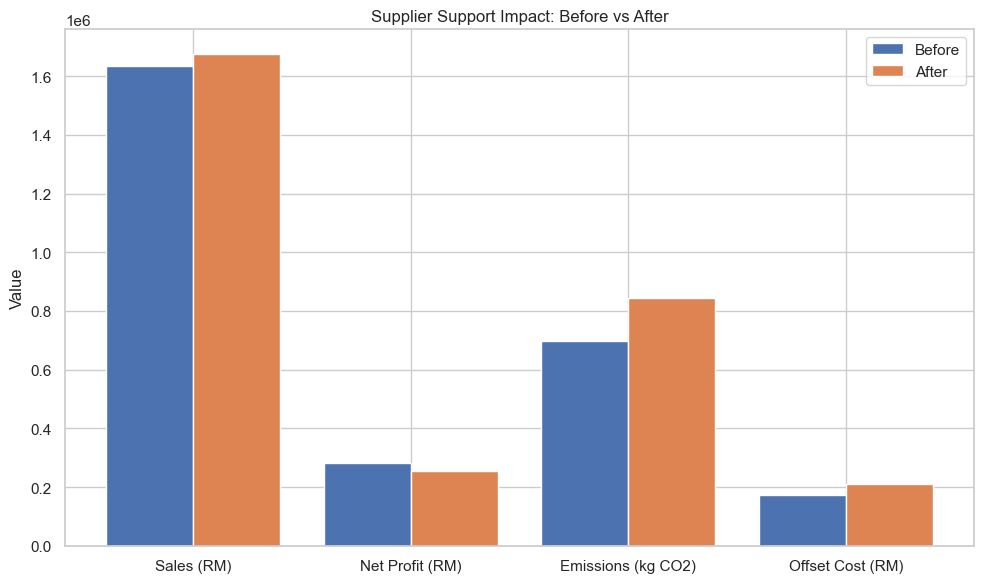

=== 📊 Final Summary with Supplier Bonus ===
Bonus Triggered? ❌ No

Previous Profit:      RM 280,841.58
Total Profit (w/bonus): RM 256,180.03 (+-8.78%)

Previous Revenue:     RM 1,635,934.79
Total Revenue:        RM 1,675,395.23 (+2.41%)

Emissions Before:     698,317.04 kg CO₂
Emissions After:      844,535.80 kg CO₂ (+20.94%)

Emissions per RM Profit (before): 2.4865 kg CO₂/RM
Emissions per RM Profit (after):  3.2966 kg CO₂/RM


In [178]:
import matplotlib.pyplot as plt

print("=== 📊 Final Summary with Supplier Bonus & Emissions Offset ===")
plot_data = {
    'Sales (RM)': [
        kpi_df.loc['Original Sales (RM)', 'Value'],
        kpi_df.loc['New Sales (RM)', 'Value']
    ],
    'Net Profit (RM)': [
        kpi_df.loc['Original Profit (RM)', 'Value'],
        kpi_df.loc['New Profit (RM)', 'Value']
    ],
    'Emissions (kg CO2)': [
        kpi_df.loc['Original Emissions (kg CO2)', 'Value'],
        kpi_df.loc['New Emissions (kg CO2)', 'Value']
    ],
    'Offset Cost (RM)': [
        kpi_df.loc['Original Offset Cost (RM)', 'Value'],
        kpi_df.loc['New Offset Cost (RM)', 'Value']
    ]
}


# Plot setup
categories = list(plot_data.keys())
before = [v[0] for v in plot_data.values()]
after = [v[1] for v in plot_data.values()]
x = range(len(categories))

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(x, before, width=0.4, label='Before', align='center')
plt.bar([i + 0.4 for i in x], after, width=0.4, label='After', align='center')
plt.xticks([i + 0.2 for i in x], categories)
plt.ylabel('Value')
plt.title('Supplier Support Impact: Before vs After')
plt.legend()
plt.tight_layout()
plt.show()


#

# Retrieve values
profit_before = kpi_df.loc['Original Profit (RM)', 'Value']
profit_after = kpi_df.loc['New Profit (RM)', 'Value']
revenue_before = kpi_df.loc['Original Sales (RM)', 'Value']
revenue_after = kpi_df.loc['New Sales (RM)', 'Value']
emissions_before = kpi_df.loc['Original Emissions (kg CO2)', 'Value']
emissions_after = kpi_df.loc['New Emissions (kg CO2)', 'Value']

# Apply bonus if applicable
bonus_triggered = revenue_after > 2_000_000
bonus_amount = 50_000 if bonus_triggered else 0
total_profit_with_bonus = profit_after + bonus_amount

# % Increases
profit_pct_increase = ((total_profit_with_bonus - profit_before) / profit_before) * 100
revenue_pct_increase = ((revenue_after - revenue_before) / revenue_before) * 100
emissions_pct_increase = ((emissions_after - emissions_before) / emissions_before) * 100

# Emissions per RM profit
emissions_per_rm_before = emissions_before / profit_before
emissions_per_rm_after = emissions_after / total_profit_with_bonus

# Output
print("=== 📊 Final Summary with Supplier Bonus ===")
print(f"Bonus Triggered? {'✅ Yes' if bonus_triggered else '❌ No'}\n")

print(f"Previous Profit:      RM {profit_before:,.2f}")
print(f"Total Profit (w/bonus): RM {total_profit_with_bonus:,.2f} (+{profit_pct_increase:.2f}%)\n")

print(f"Previous Revenue:     RM {revenue_before:,.2f}")
print(f"Total Revenue:        RM {revenue_after:,.2f} (+{revenue_pct_increase:.2f}%)\n")

print(f"Emissions Before:     {emissions_before:,.2f} kg CO₂")
print(f"Emissions After:      {emissions_after:,.2f} kg CO₂ (+{emissions_pct_increase:.2f}%)\n")

print(f"Emissions per RM Profit (before): {emissions_per_rm_before:.4f} kg CO₂/RM")
print(f"Emissions per RM Profit (after):  {emissions_per_rm_after:.4f} kg CO₂/RM")


***Identifying the Best Trade-Off In Discount***

_After a bit of research, a golden-section search was implemented to help determine the best discount %_

In [180]:
def objective_function(discount_rate):
    df = supplier_support_df.copy()

    # Step 1: New price after discount
    df['NewPrice'] = df['PredictedPrice'] * (1 - discount_rate)

    # Step 2: % change in price
    df['PctPriceChange'] = (df['NewPrice'] - df['PredictedPrice']) / df['PredictedPrice']

    # Step 3: Volume response using elasticity
    df['PctVolumeChange'] = -df['Elasticity'] * df['PctPriceChange']
    df['NewVolume'] = df['EstimatedUnitVolume'] * (1 + df['PctVolumeChange'])
    df['NewVolume'] = df['NewVolume'].clip(lower=0)

    # Step 4: Recalculate sales and profit
    df['NewSales'] = df['NewPrice'] * df['NewVolume']
    df['NewGrossProfit'] = df['NewSales'] * df['Margin']

    # Step 5: Emissions and offset cost
    df['NewEmissions'] = df['NewVolume'] * df['Total_Emissions_per_Unit']
    df['OffsetCost'] = df['NewEmissions'] * 0.25

    # Step 6: Net profit = gross profit − offset cost
    df['NewNetProfit'] = df['NewGrossProfit'] - df['OffsetCost']

    total_sales = df['NewSales'].sum()
    total_net_profit = df['NewNetProfit'].sum()

    # Step 7: Bonus condition
    if total_sales > 2_000_000:
        total_net_profit += 50_000

    return total_net_profit


In [138]:
import numpy as np

def golden_section_search(f, a=0.05, b=0.5, tol=1e-4, max_iter=50):
    gr = (np.sqrt(5) + 1) / 2  # golden ratio ≈ 1.618
    c = b - (b - a) / gr
    d = a + (b - a) / gr

    fc = f(c)
    fd = f(d)

    for i in range(max_iter):
        if abs(b - a) < tol:
            break

        if fc > fd:
            b, d = d, c
            fd = fc
            c = b - (b - a) / gr
            fc = f(c)
        else:
            a, c = c, d
            fc = fd
            d = a + (b - a) / gr
            fd = f(d)

    # Best point is midpoint of final range
    best_discount = (a + b) / 2
    best_profit = f(best_discount)
    return best_discount, best_profit


In [182]:
best_discount, best_profit = golden_section_search(objective_function)
print(f"✅ Optimal Discount Rate: {best_discount:.4f} ({best_discount*100:.2f}%)")
print(f"💰 Estimated Max Profit: RM {best_profit:,.2f}")


✅ Optimal Discount Rate: 0.0500 (5.00%)
💰 Estimated Max Profit: RM 275,763.79


In [150]:
# Re-run calculations at the best discount to get full breakdown
optimal_df = supplier_support_df.copy()
discount = best_discount

# Recompute all values
optimal_df['NewPrice'] = optimal_df['PredictedPrice'] * (1 - discount)
optimal_df['PctPriceChange'] = (optimal_df['NewPrice'] - optimal_df['PredictedPrice']) / optimal_df['PredictedPrice']
optimal_df['PctVolumeChange'] = -optimal_df['Elasticity'] * optimal_df['PctPriceChange']
optimal_df['NewVolume'] = optimal_df['EstimatedUnitVolume'] * (1 + optimal_df['PctVolumeChange'])
optimal_df['NewVolume'] = optimal_df['NewVolume'].clip(lower=0)
optimal_df['NewSales'] = optimal_df['NewPrice'] * optimal_df['NewVolume']
optimal_df['NewGrossProfit'] = optimal_df['NewSales'] * optimal_df['Margin']
optimal_df['NewEmissions'] = optimal_df['NewVolume'] * optimal_df['Total_Emissions_per_Unit']
optimal_df['NewOffsetCost'] = optimal_df['NewEmissions'] * 0.25
optimal_df['NewNetProfit'] = optimal_df['NewGrossProfit'] - optimal_df['NewOffsetCost']

# Totals (after emissions cost)
prev_profit = supplier_support_df['OrigProfit'].sum()
prev_sales = supplier_support_df['OrigSales'].sum()
prev_emissions = supplier_support_df['OrigEmissions'].sum()

new_profit = optimal_df['NewNetProfit'].sum()
new_sales = optimal_df['NewSales'].sum()
new_emissions = optimal_df['NewEmissions'].sum()

# Bonus logic
bonus_triggered = new_sales > 2_000_000
bonus_amount = 50_000 if bonus_triggered else 0
new_profit_with_bonus = new_profit + bonus_amount

# Emissions per RM profit
emissions_per_rm_before = prev_emissions / prev_profit
emissions_per_rm_after = new_emissions / new_profit_with_bonus

# % Changes
profit_pct_increase = ((new_profit_with_bonus - prev_profit) / prev_profit) * 100
sales_pct_increase = ((new_sales - prev_sales) / prev_sales) * 100
emissions_pct_increase = ((new_emissions - prev_emissions) / prev_emissions) * 100

# Final Printout
print("=== 📊 Optimized Supplier Support Summary (Net Profit after CO₂ Cost) ===")
print(f"Optimal Discount Rate: {discount:.4f} ({discount*100:.2f}%)")
print(f"Bonus Triggered? {'✅ Yes' if bonus_triggered else '❌ No'}\n")

print(f"Previous Net Profit:      RM {prev_profit:,.2f}")
print(f"Total Net Profit (w/bonus): RM {new_profit_with_bonus:,.2f} (+{profit_pct_increase:.2f}%)\n")

print(f"Previous Revenue:     RM {prev_sales:,.2f}")
print(f"Total Revenue:        RM {new_sales:,.2f} (+{sales_pct_increase:.2f}%)\n")

print(f"Emissions Before:     {prev_emissions:,.2f} kg CO₂")
print(f"Emissions After:      {new_emissions:,.2f} kg CO₂ (+{emissions_pct_increase:.2f}%)\n")

print(f"Emissions per RM Net Profit (before): {emissions_per_rm_before:.4f} kg CO₂/RM")
print(f"Emissions per RM Net Profit (after):  {emissions_per_rm_after:.4f} kg CO₂/RM")


=== 📊 Optimized Supplier Support Summary ===
Optimal Discount Rate: 0.1381 (13.81%)
Bonus Triggered? ❌ No

Previous Profit:      RM 455,420.85
Total Profit (w/bonus): RM 467,413.31 (+2.63%)

Previous Revenue:     RM 1,635,934.79
Total Revenue:        RM 1,675,969.05 (+2.45%)

Emissions Before:     698,317.04 kg CO₂
Emissions After:      832,902.17 kg CO₂ (+19.27%)

Emissions per RM Profit (before): 1.5333 kg CO₂/RM
Emissions per RM Profit (after):  1.7819 kg CO₂/RM
